<a href="https://colab.research.google.com/github/lazybear-0425/EWC_Observation/blob/main/2025-03-24_21_40_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 - Life Lone Learning
 - Elastic Weight Consolidation (EWC)
    - [教學](https://www.kaggle.com/code/hughiephan/elastic-weight-consolidation-on-minst)
    - [Paper](https://arxiv.org/pdf/1612.00796)
    - 公式 $\mathcal{L}(\theta) = \mathcal{L}_B(\theta) + \frac\lambda2\sum^n_{i=1}F_i(\theta_i - \theta^*_{A,i})^2$
        - B是指目前任務，A是指前一個任務
 - [教學2](https://github.com/ContinualAI/colab/blob/master/notebooks/intro_to_continual_learning.ipynb)

In [55]:
import torch
from torch import nn
from torchvision.transforms import Compose, ToTensor, Normalize, RandomRotation, Lambda
import numpy as np
from torchvision.datasets import MNIST as FashionMNIST
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torch.nn import CrossEntropyLoss
from torch.optim import Adam, SGD
from torch.nn.functional import cross_entropy

In [56]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [57]:
batch_size = 256
epochs = 10
task = 2

 - [ToTensor](https://pytorch.org/vision/main/generated/torchvision.transforms.ToTensor.html)

In [58]:
def trans_compose(i=0):
    return Compose([
        # lambda x : np.rot90(x, i, axes=[0, 1]).copy(), # 使連續
        # lambda x: np.expand_dims(x, axis=-1),  # 因為ToTensor要PIL or ndarray(H x W x C)，之後轉成Tensor(C x H x W)
        ToTensor(),
        # Lambda(lambda x : x / 255.),
        RandomRotation((90 * i, 90 * i)),
        Normalize(mean=[0.0], std=[1])
    ])

In [59]:
# preprocessing
# train_task_1 = FashionMNIST('data', train=True, transform=trans_compose(0), download=True)
# train_task_2 = FashionMNIST('data', train=True, transform=trans_compose(1), download=True)

test_task_1 = FashionMNIST('data', train=False, transform=trans_compose(0), download=True)
test_task_2 = FashionMNIST('data', train=False, transform=trans_compose(1), download=True)

task_1_loader = DataLoader(test_task_1, batch_size=batch_size)
task_2_loader = DataLoader(test_task_2, batch_size=batch_size)

In [60]:
class Module(nn.Module):
    def __init__(self):
        super(Module, self).__init__()
        # self.classifier = nn.Sequential(
        #     nn.Conv2d(1, 10, kernel_size=5),
        #     nn.MaxPool2d(2),
        #     nn.ReLU(),
        #     nn.Conv2d(10, 20, kernel_size=5),
        #     nn.Dropout2d(),
        #     nn.MaxPool2d(2),
        #     nn.ReLU(),
        # )
        # self.dense = nn.Sequential(
        #     nn.Linear(320, 50),
        #     nn.ReLU(),
        #     nn.Dropout(),
        #     nn.Linear(50, 10)
        # )
        self.net = nn.Sequential(
            # nn.Flatten(),
            # nn.LazyLinear(10),
            nn.Conv2d(1, 10, kernel_size=3, padding=1, stride=2),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.Conv2d(10, 5, kernel_size=3, padding=1, stride=2),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.BatchNorm2d(5),
            nn.Flatten(),
            nn.LazyLinear(10)
        )
    def forward(self, X):
        # return self.dense(self.classifier(X).view(-1, 320))
        return self.net(X)

In [61]:
def evaluate(model, dataloader, num_data, num_task=-1):
    if num_task < 0: raise ValueError("Task Number is Missing")

    test_acc = 0
    test_loss = 0
    with torch.no_grad():
        model.eval()
        for data in dataloader:
            img, label = data
            img, label = img.to(device), label.to(device).long()
            output = model(img)
            test_loss += cross_entropy(output, label)
            test_acc += (output.argmax(1) == label).sum()
    print('\033[33m' +
          f'Task {num_task} Acc: {test_acc / num_data: .4f}, Loss: {test_loss / num_data: .4f}' +
          '\033[0m')

In [62]:
def training_Setting(model):
    optimizer = Adam(model.parameters())
    loss = CrossEntropyLoss()
    return optimizer, loss

 - Fisher Matrix
     - 儲存權重對模型重要性
     - 計算方法
         - [LINK](https://github.com/db434/EWC)
             - 這個版本是**取樣** $\rightarrow$ 計算梯度
         - 這邊的範例程式碼是直接**整個資料**來計算梯度
         - 公式
             - $F_j = \frac1m \sum^m_{i=1}(\frac{\partial \log (P(x_i|\theta_j))}{\partial \theta_j})^2$

In [63]:
# EWC
optim_para = {}
fisher_matrix = {}
ewc_lambda = 25

def record_parameter(model, train_data, optimizer, num_task=-1):
    if num_task < 0: raise ValueError("Task Number is Missing")
    global optim_para, fisher_matrix, ewc_lambda
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    model.train()
    optimizer.zero_grad()

    fisher_matrix[num_task] = {}
    optim_para[num_task] = {}

    # Initialize Fisher Matrix
    for name, param in model.named_parameters():
        fisher_matrix[num_task][name] = torch.zeros_like(param.data)

    # Calculate Fisher Matrix
    for data in train_loader:
        img, label = data
        img, label = img.to(device), label.to(device).long()
        output = model(img)
        output_loss = cross_entropy(output, label)
        output_loss.backward()

        for name, param in model.named_parameters():
            if param.grad is not None:
                fisher_matrix[num_task][name] += param.grad.data.clone().pow(2)

    # Average Fisher Matrix
    for name, param in model.named_parameters():
        fisher_matrix[num_task][name] /= len(train_loader)

    # Save optimal parameters
    for name, param in model.named_parameters():
        optim_para[num_task][name] = param.data.clone()

In [64]:
def training(model, test_loader : list, test_num : list, epochs = 10,  num_task=-1):
    if num_task < 0: raise ValueError("Task Number is Missing")
    global optim_para, fisher_matrix, ewc_lambda
    print(f'Task {num_task} Start!')

    train_data = FashionMNIST('data', train=True, transform=trans_compose(num_task), download=True)
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    # plt.imshow(train_data[0][0].reshape(28, 28), cmap='gray')
    # plt.title('Task' + str(num_task))
    # plt.show()

    # optimizer, loss = training_Setting(model)
    optimizer = Adam(model.parameters()) #SGD(model.parameters(), lr=0.01, momentum=0.9)
    
    for i in range(epochs):
        model.train()
        train_acc = 0
        train_loss = 0
        for data in train_loader:
            optimizer.zero_grad()

            img, label = data
            img, label = img.to(device), label.to(device).long()
            output = model(img)
            output_loss = cross_entropy(output, label)
            # Record
            train_acc += (output.argmax(1) == label).sum()
            # BP
            ewc_loss = 0
            for t in range(num_task):
                for name, param in model.named_parameters():
                    if t in optim_para:
                        fisher = fisher_matrix[t][name]
                        optim = optim_para[t][name]
                        if fisher.requires_grad == True or optim.requires_grad == True:
                            raise NotImplementedError('Frozen it!')
                        # output_loss += ewc_lambda * (fisher * (optim - param).pow(2)).sum() # .detach()
                        ewc_loss += (fisher * (optim - param).pow(2)).sum() * ewc_lambda
            # if tmp != 0: print(tmp)
            output_loss += ewc_loss
            train_loss += output_loss.detach()
            output_loss.backward()
            optimizer.step()
        print(f'Epoch\t{i + 1}\tAcc: {train_acc / len(train_data): .4f}, Loss: {train_loss / len(train_data): .4f}')
    record_parameter(model, train_data, optimizer, num_task=num_task)
    # Evaluate Task 0 & 1
    task_id = 0
    for num_data, loader in zip(test_num, test_loader):
        evaluate(model, loader, num_data, task_id)
        task_id = task_id + 1
    print() # End of Training

 - nn.Module
    - named_pa​​rameters()
         - 給出網絡層的名字和參數的迭代器
    - parameters()
         - 參數的迭代器
    - [Reference](https://blog.csdn.net/qq_36530992/article/details/102729585)

In [65]:
from torchsummary import summary
model = Module().to(device)
summary(model, (1, 28, 28))

for i in range(task):
    training(model, [task_1_loader, task_2_loader], [len(test_task_1), len(test_task_2)], num_task=i, epochs=epochs)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 14, 14]             100
         MaxPool2d-2             [-1, 10, 7, 7]               0
              ReLU-3             [-1, 10, 7, 7]               0
       BatchNorm2d-4             [-1, 10, 7, 7]              20
            Conv2d-5              [-1, 5, 4, 4]             455
         MaxPool2d-6              [-1, 5, 2, 2]               0
              ReLU-7              [-1, 5, 2, 2]               0
       BatchNorm2d-8              [-1, 5, 2, 2]              10
           Flatten-9                   [-1, 20]               0
           Linear-10                   [-1, 10]             210
Total params: 795
Trainable params: 795
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.03
Params size (MB): 0.00
Estimated Total Siz

 - Task 0

Accuracy 0.5591
Classification Report
              precision    recall  f1-score   support

    0 - zero       0.64      0.63      0.63       980
     1 - one       0.69      0.84      0.76      1135
     2 - two       0.42      0.90      0.57      1032
   3 - three       0.37      0.50      0.42      1010
    4 - four       0.63      0.44      0.52       982
    5 - five       0.59      0.13      0.21       892
     6 - six       0.77      0.65      0.71       958
   7 - seven       0.68      0.28      0.39      1028
   8 - eight       0.48      0.69      0.57       974
    9 - nine       0.78      0.47      0.58      1009

    accuracy                           0.56     10000
   macro avg       0.61      0.55      0.54     10000
weighted avg       0.61      0.56      0.54     10000



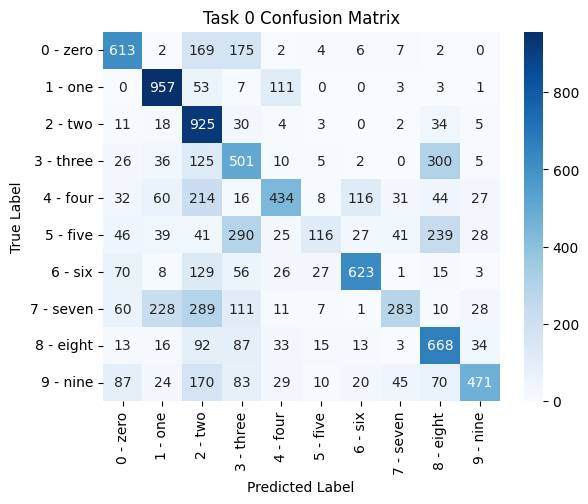

In [66]:
true_label = []
pred_label = []
with torch.no_grad():
    for data in task_1_loader:
        img, label = data
        img, label = img.to(device), label.to(device)
        output = model(img).argmax(1)
        true_label.extend(label.cpu().numpy())
        pred_label.extend(output.cpu().numpy())

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
print('\033[33m' + 'Accuracy' + '\033[0m', accuracy_score(true_label, pred_label))
print('\033[33m' + 'Classification Report' + '\033[0m',
      classification_report(true_label, pred_label, target_names=test_task_1.classes),
      sep='\n')
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(true_label, pred_label)
plt.cla(); plt.clf()
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_task_1.classes, yticklabels=test_task_1.classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Task 0 Confusion Matrix")
plt.show()

 - Task 1

Accuracy 0.4587
Classification Report
              precision    recall  f1-score   support

    0 - zero       0.63      0.67      0.65       980
     1 - one       0.61      0.79      0.69      1135
     2 - two       0.45      0.40      0.43      1032
   3 - three       0.35      0.31      0.33      1010
    4 - four       0.25      0.19      0.22       982
    5 - five       0.38      0.38      0.38       892
     6 - six       0.48      0.43      0.46       958
   7 - seven       0.44      0.66      0.53      1028
   8 - eight       0.45      0.48      0.46       974
    9 - nine       0.39      0.21      0.28      1009

    accuracy                           0.46     10000
   macro avg       0.44      0.45      0.44     10000
weighted avg       0.44      0.46      0.44     10000



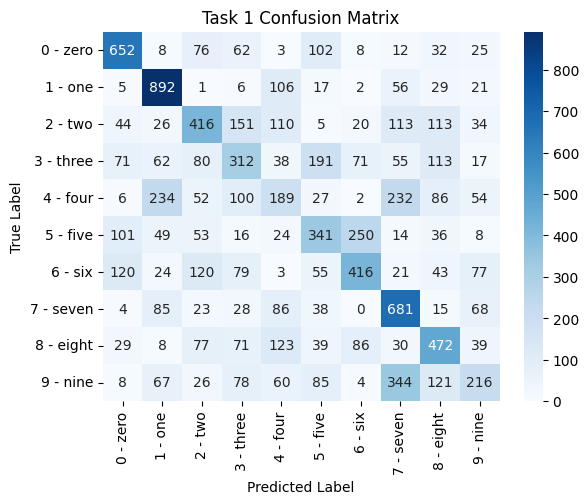

In [67]:
true_label = []
pred_label = []
with torch.no_grad():
    for data in task_2_loader:
        img, label = data
        img, label = img.to(device), label.to(device)
        output = model(img).argmax(1)
        true_label.extend(label.cpu().numpy())
        pred_label.extend(output.cpu().numpy())

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
print('\033[33m' + 'Accuracy' + '\033[0m', accuracy_score(true_label, pred_label))
print('\033[33m' + 'Classification Report' + '\033[0m',
      classification_report(true_label, pred_label, target_names=test_task_2.classes),
      sep='\n')
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(true_label, pred_label)
plt.cla(); plt.clf()
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_task_2.classes, yticklabels=test_task_2.classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Task 1 Confusion Matrix")
plt.show()

net.0.weight
torch.Size([10, 1, 3, 3])
Max fisher is 0.00000 and it's parameter diff is 0.00000
Min Parameter diff is 0.00000 and it's fisher is 0.00000
fisher > parameter diff: 0
fisher <= parameter diff: 9


<Figure size 640x480 with 0 Axes>

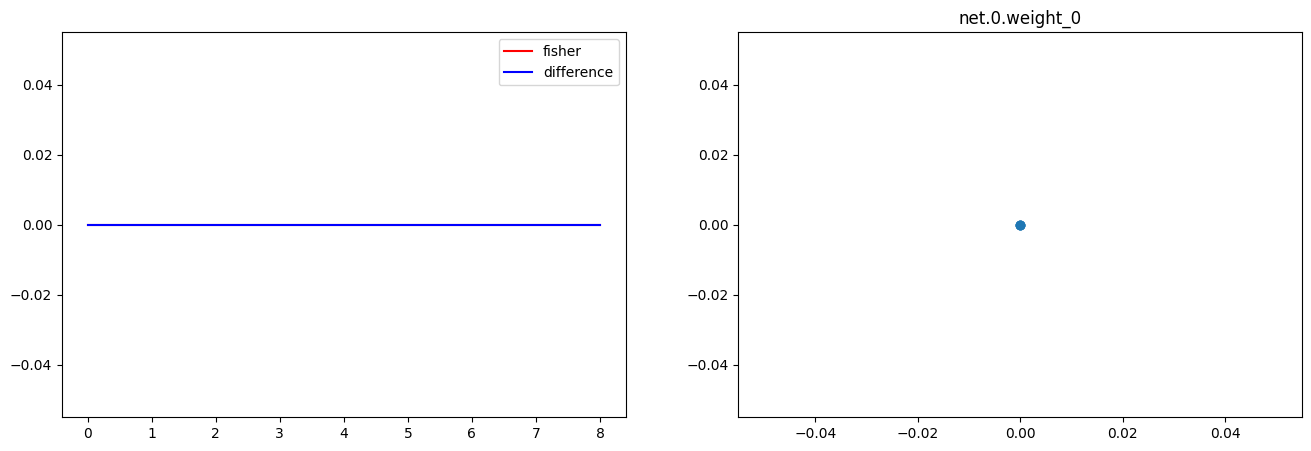

Max fisher is 1.57302 and it's parameter diff is 0.00040
Min Parameter diff is 0.02166 and it's fisher is 0.14023
fisher > parameter diff: 9
fisher <= parameter diff: 0


<Figure size 640x480 with 0 Axes>

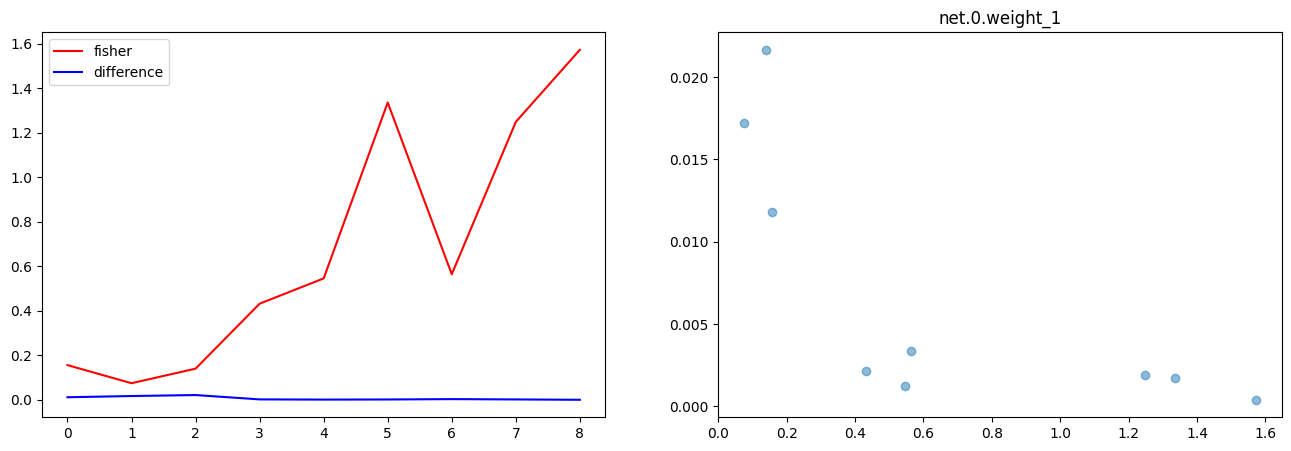

Max fisher is 0.46044 and it's parameter diff is 0.01369
Min Parameter diff is 0.20736 and it's fisher is 0.04373
fisher > parameter diff: 5
fisher <= parameter diff: 4


<Figure size 640x480 with 0 Axes>

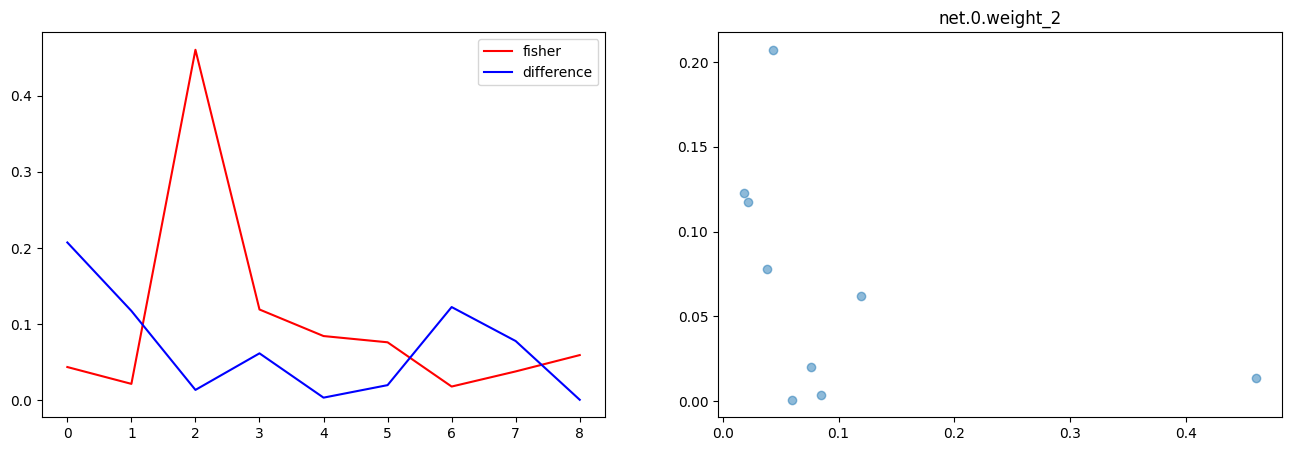

Max fisher is 11.02239 and it's parameter diff is 0.00014
Min Parameter diff is 0.01638 and it's fisher is 0.08385
fisher > parameter diff: 9
fisher <= parameter diff: 0


<Figure size 640x480 with 0 Axes>

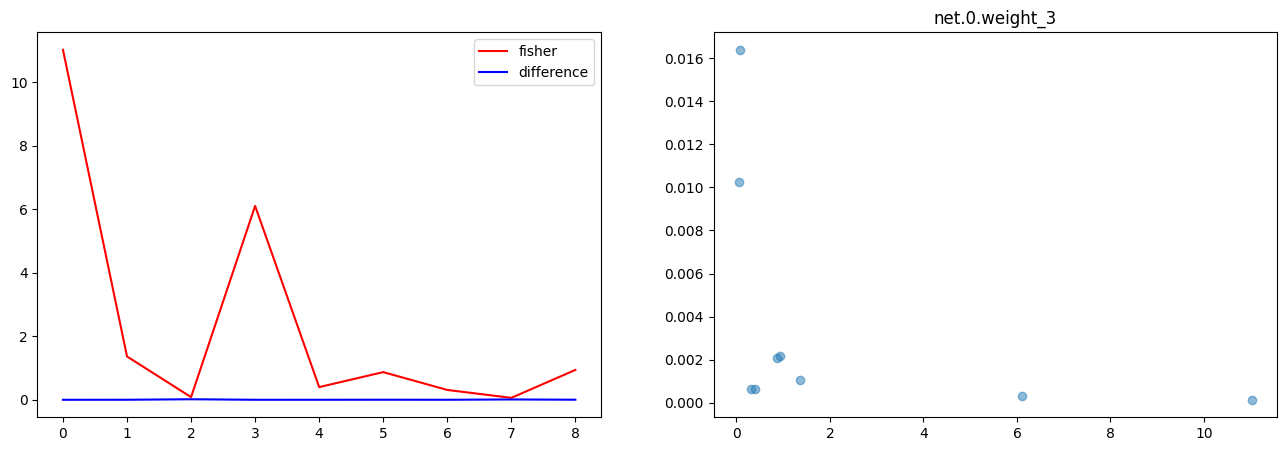

Max fisher is 3.80303 and it's parameter diff is 0.00038
Min Parameter diff is 0.03159 and it's fisher is 0.03258
fisher > parameter diff: 8
fisher <= parameter diff: 1


<Figure size 640x480 with 0 Axes>

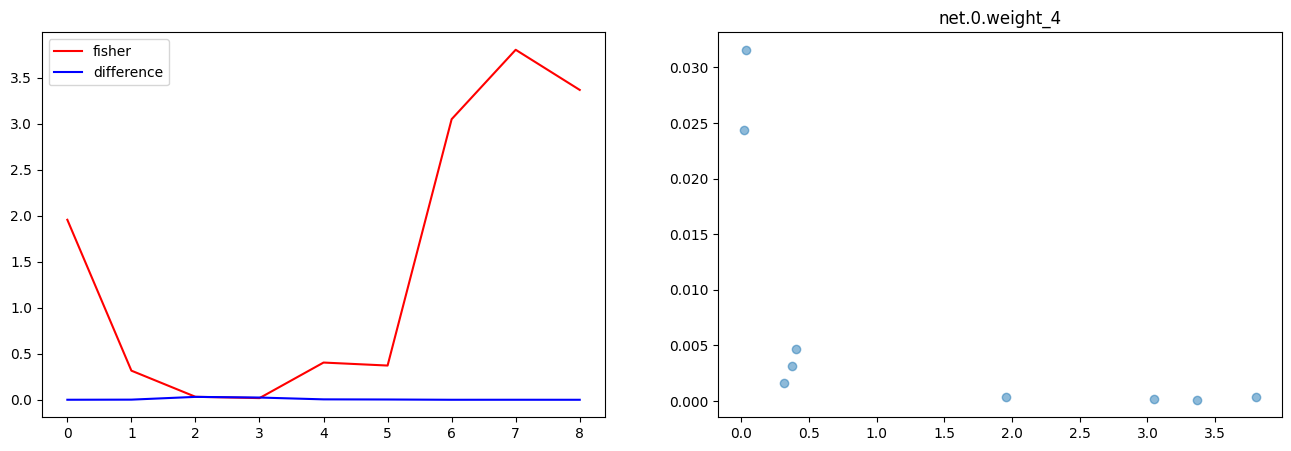

Max fisher is 0.29078 and it's parameter diff is 0.00125
Min Parameter diff is 0.01788 and it's fisher is 0.09358
fisher > parameter diff: 9
fisher <= parameter diff: 0


<Figure size 640x480 with 0 Axes>

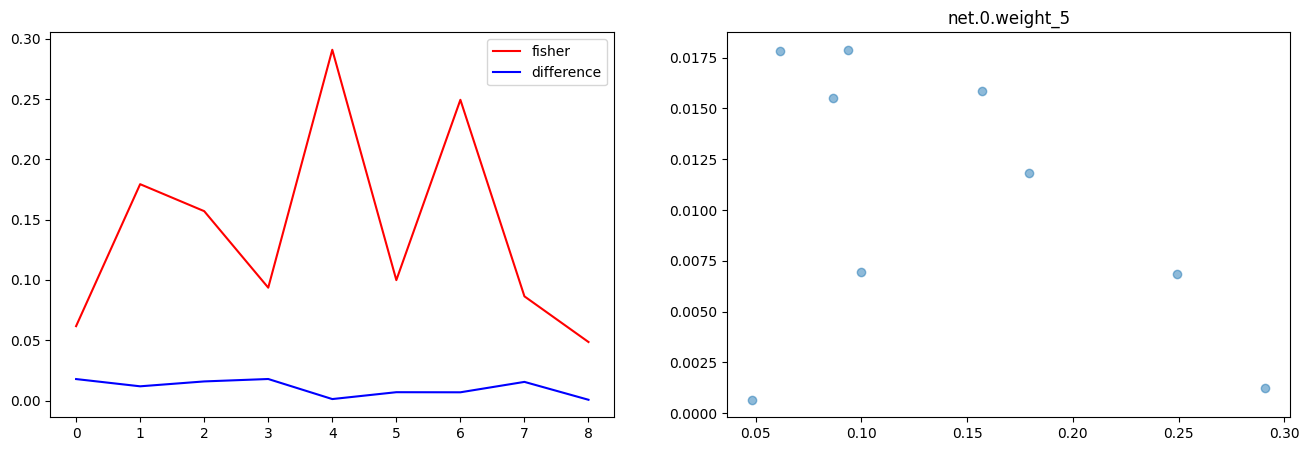

Max fisher is 1.82450 and it's parameter diff is 0.00162
Min Parameter diff is 0.08483 and it's fisher is 0.02872
fisher > parameter diff: 8
fisher <= parameter diff: 1


<Figure size 640x480 with 0 Axes>

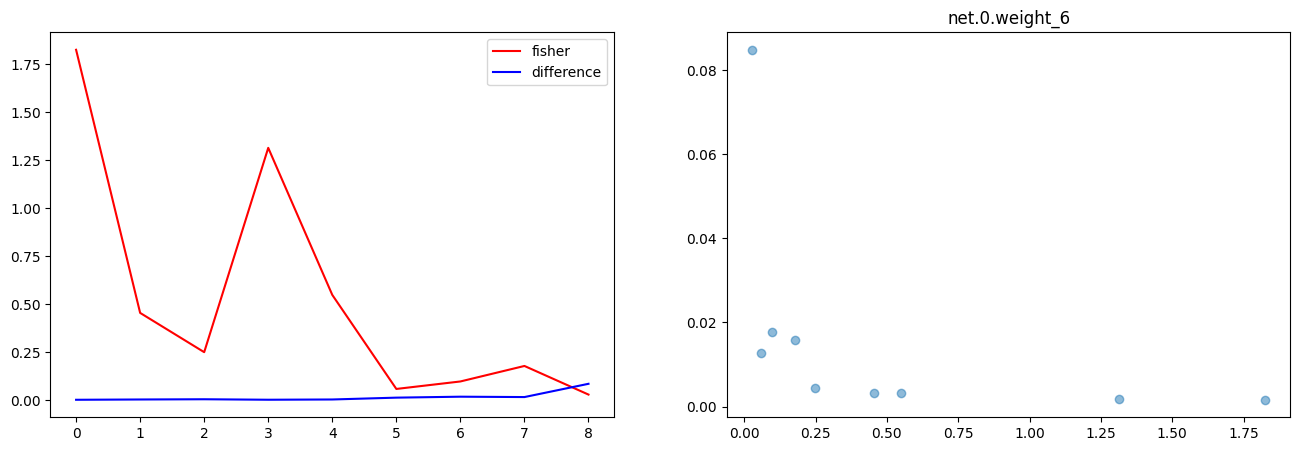

Max fisher is 9.12414 and it's parameter diff is 0.00082
Min Parameter diff is 0.00863 and it's fisher is 0.45896
fisher > parameter diff: 9
fisher <= parameter diff: 0


<Figure size 640x480 with 0 Axes>

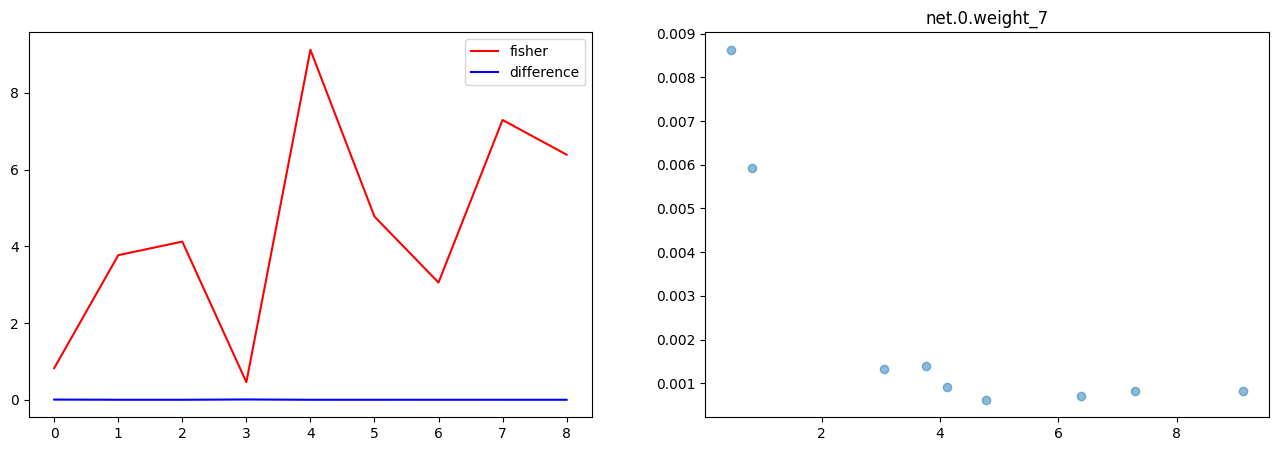

Max fisher is 0.00000 and it's parameter diff is 0.00000
Min Parameter diff is 0.00000 and it's fisher is 0.00000
fisher > parameter diff: 3
fisher <= parameter diff: 6


<Figure size 640x480 with 0 Axes>

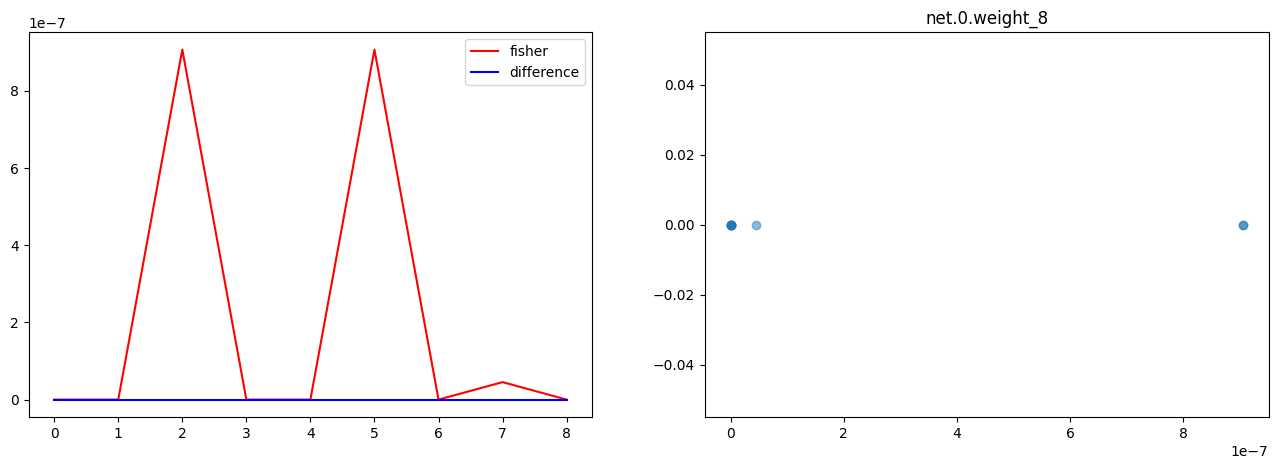

Max fisher is 0.00000 and it's parameter diff is 0.00089
Min Parameter diff is 0.01987 and it's fisher is 0.00000
fisher > parameter diff: 0
fisher <= parameter diff: 9


<Figure size 640x480 with 0 Axes>

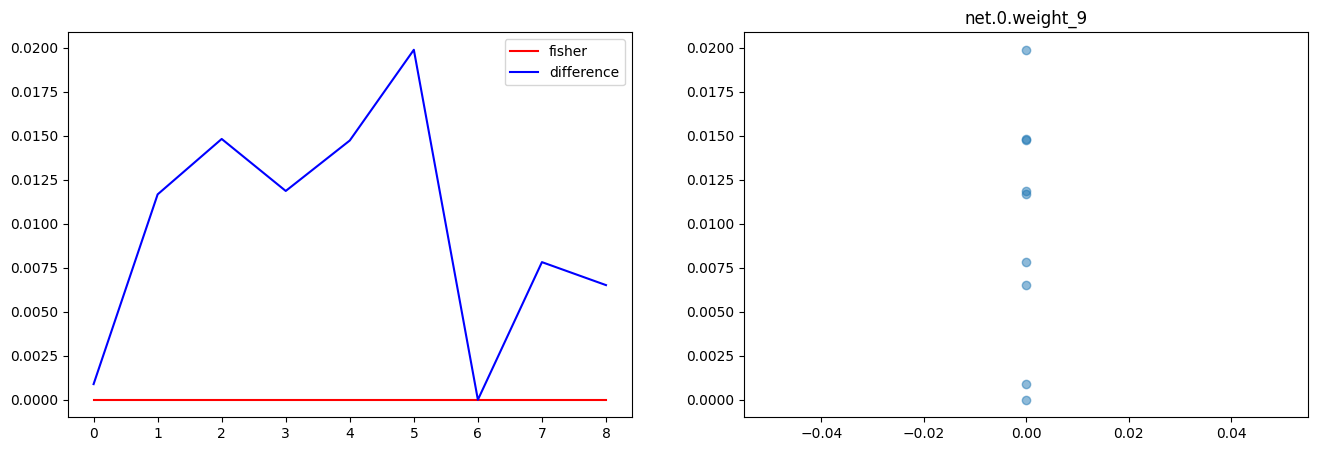


net.0.bias
torch.Size([10])
Max fisher is 11.69053 and it's parameter diff is 0.00037
Min Parameter diff is 0.01138 and it's fisher is 0.00000
fisher > parameter diff: 6
fisher <= parameter diff: 4


<Figure size 640x480 with 0 Axes>

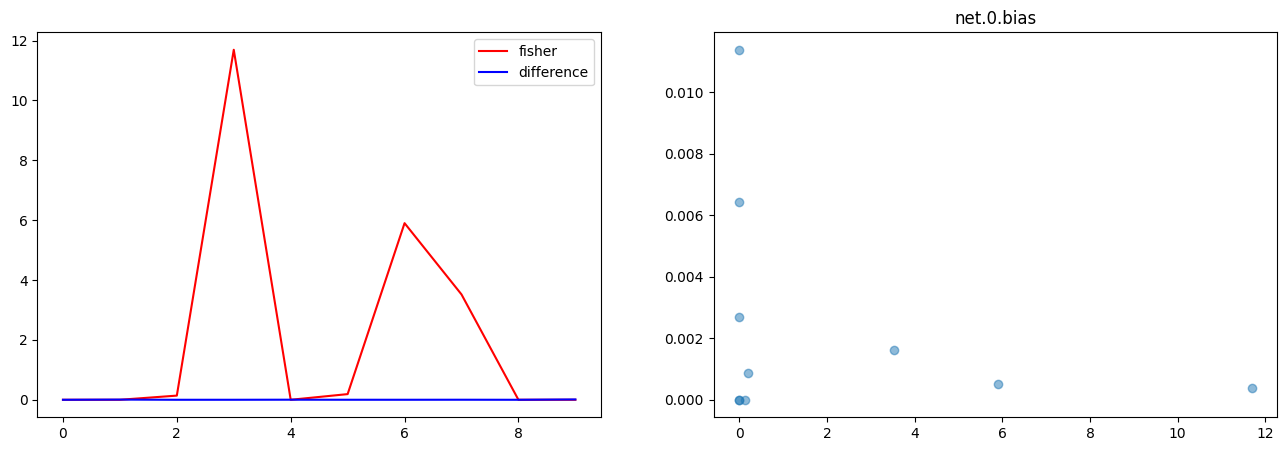


net.3.weight
torch.Size([10])
Max fisher is 1.05148 and it's parameter diff is 0.00197
Min Parameter diff is 0.01027 and it's fisher is 0.33321
fisher > parameter diff: 8
fisher <= parameter diff: 2


<Figure size 640x480 with 0 Axes>

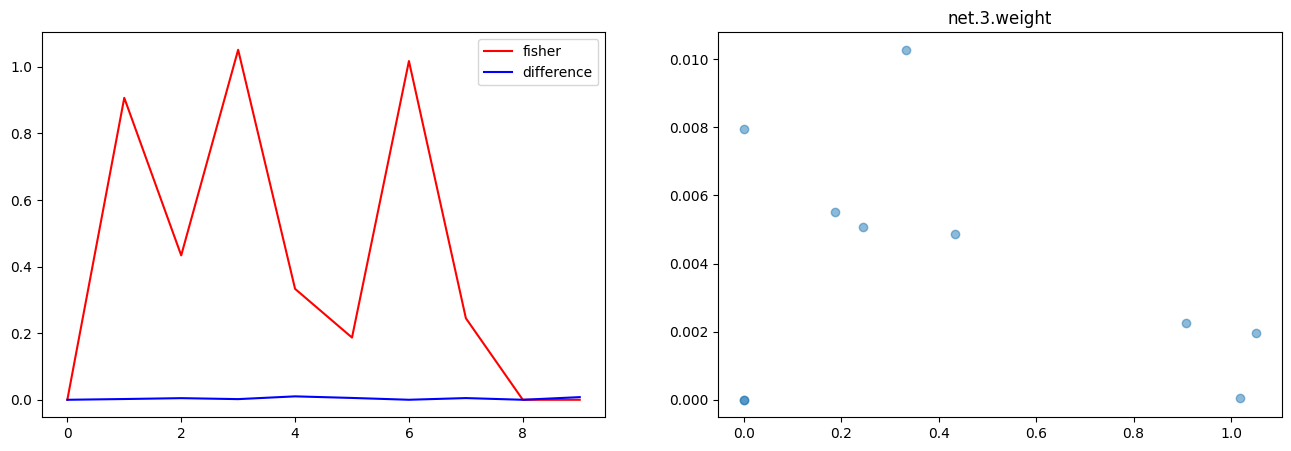


net.3.bias
torch.Size([10])
Max fisher is 0.51711 and it's parameter diff is 0.00201
Min Parameter diff is 0.14363 and it's fisher is 0.00277
fisher > parameter diff: 6
fisher <= parameter diff: 4


<Figure size 640x480 with 0 Axes>

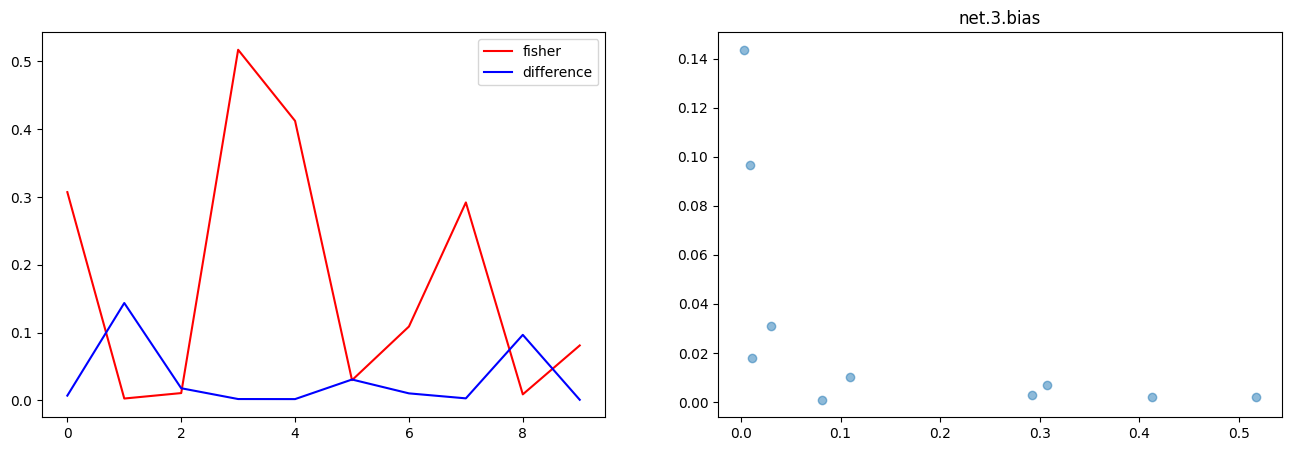


net.4.weight
torch.Size([5, 10, 3, 3])
Max fisher is 23.18730 and it's parameter diff is 0.00014
Min Parameter diff is 0.05554 and it's fisher is 0.00749
fisher > parameter diff: 84
fisher <= parameter diff: 6


<Figure size 640x480 with 0 Axes>

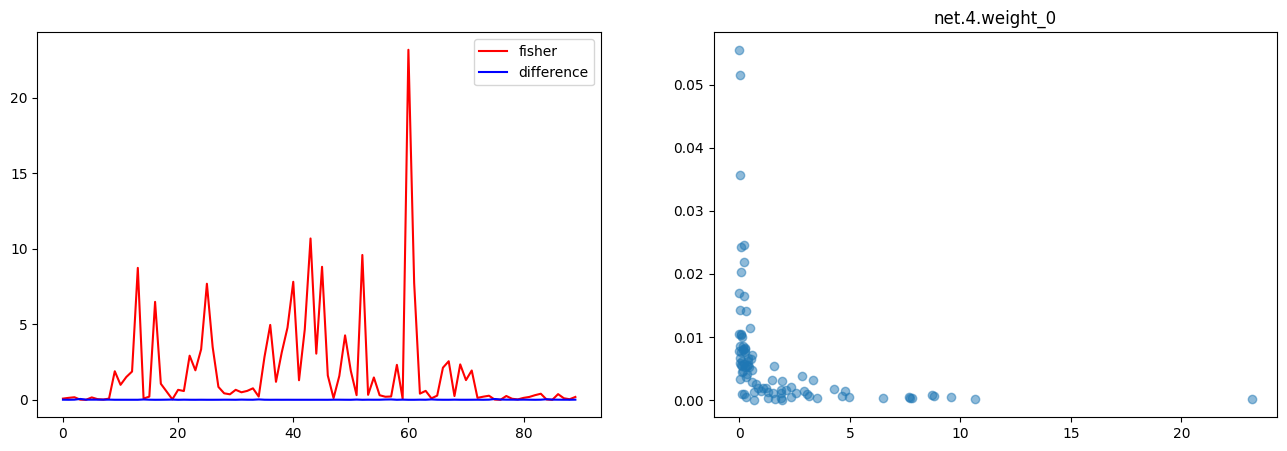

Max fisher is 6.96420 and it's parameter diff is 0.00022
Min Parameter diff is 0.61808 and it's fisher is 0.00067
fisher > parameter diff: 62
fisher <= parameter diff: 28


<Figure size 640x480 with 0 Axes>

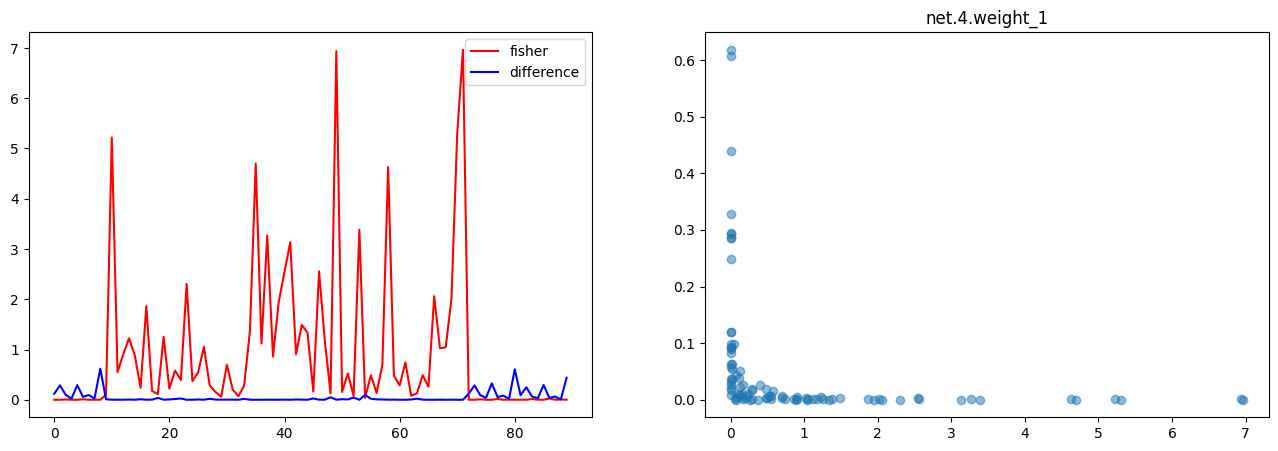

Max fisher is 27.33833 and it's parameter diff is 0.00003
Min Parameter diff is 0.38088 and it's fisher is 0.00001
fisher > parameter diff: 73
fisher <= parameter diff: 17


<Figure size 640x480 with 0 Axes>

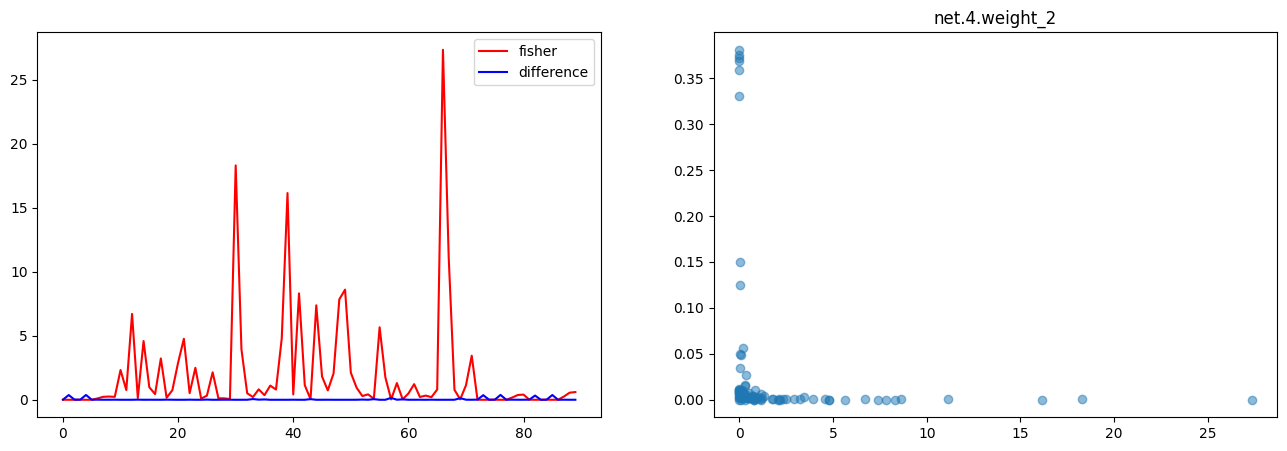

Max fisher is 16.25901 and it's parameter diff is 0.00068
Min Parameter diff is 0.39499 and it's fisher is 0.00002
fisher > parameter diff: 68
fisher <= parameter diff: 22


<Figure size 640x480 with 0 Axes>

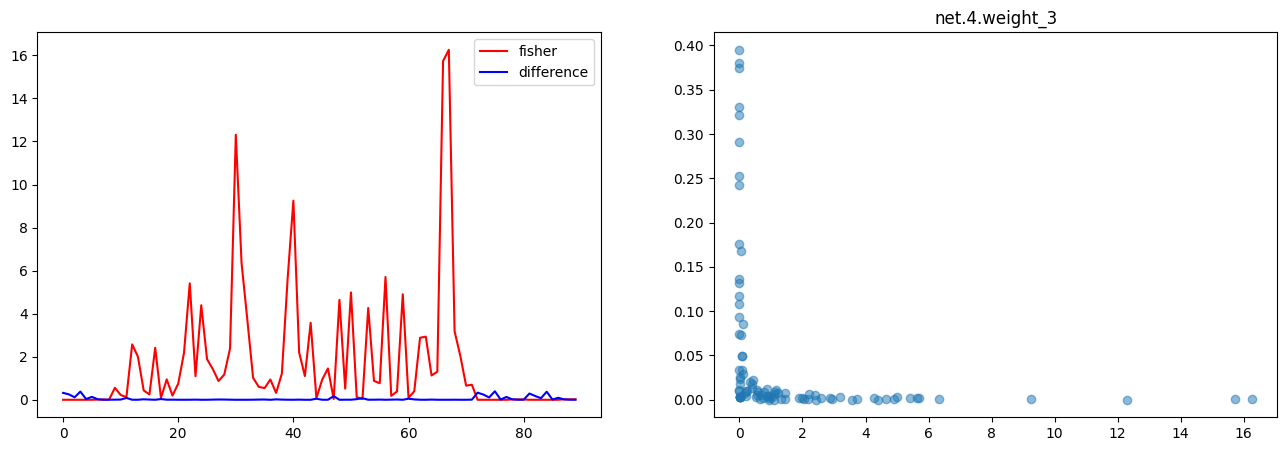

Max fisher is 13.47099 and it's parameter diff is 0.00003
Min Parameter diff is 0.18509 and it's fisher is 0.00101
fisher > parameter diff: 78
fisher <= parameter diff: 12


<Figure size 640x480 with 0 Axes>

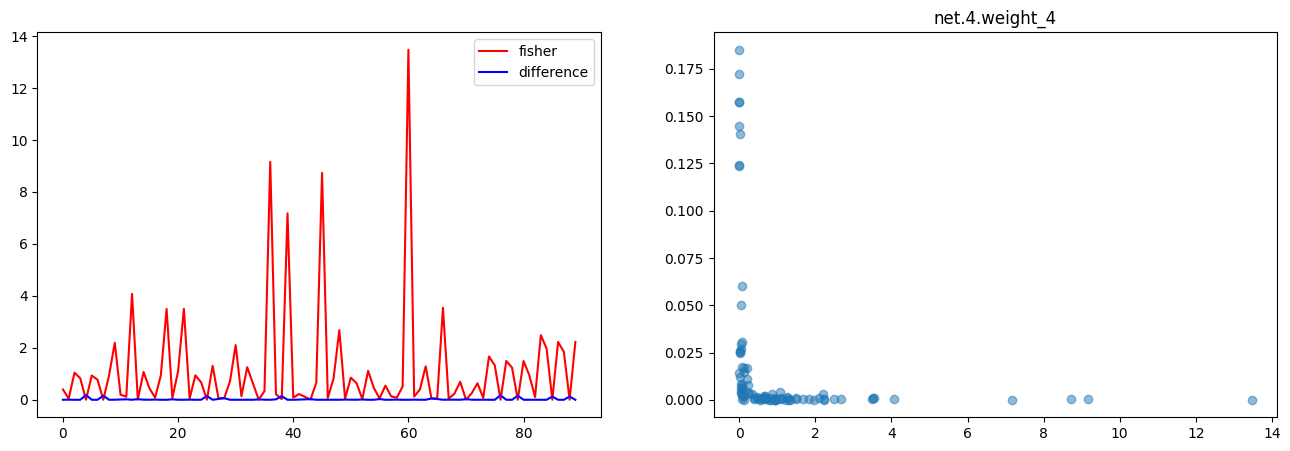


net.4.bias
torch.Size([5])
Max fisher is 0.00634 and it's parameter diff is 0.07477
Min Parameter diff is 0.36287 and it's fisher is 0.00006
fisher > parameter diff: 0
fisher <= parameter diff: 5


<Figure size 640x480 with 0 Axes>

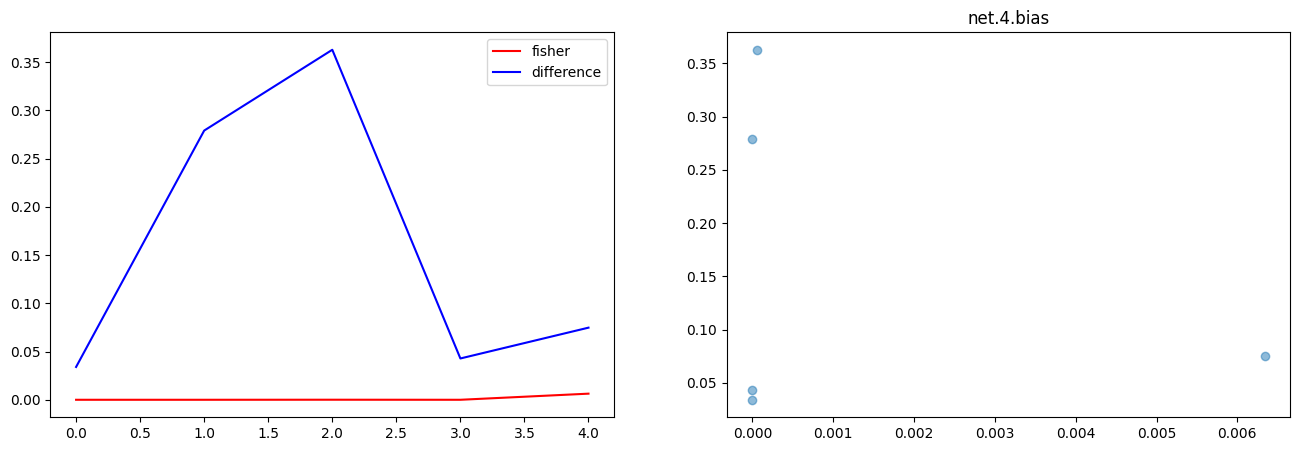


net.7.weight
torch.Size([5])
Max fisher is 0.69503 and it's parameter diff is 0.00021
Min Parameter diff is 0.10059 and it's fisher is 0.03053
fisher > parameter diff: 4
fisher <= parameter diff: 1


<Figure size 640x480 with 0 Axes>

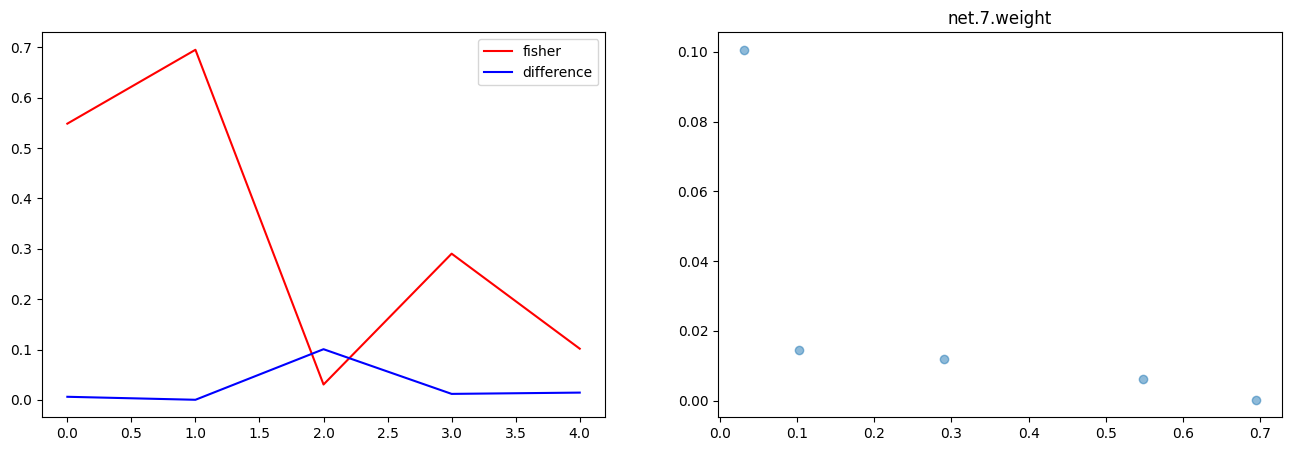


net.7.bias
torch.Size([5])
Max fisher is 0.36495 and it's parameter diff is 0.00426
Min Parameter diff is 0.06103 and it's fisher is 0.01536
fisher > parameter diff: 3
fisher <= parameter diff: 2


<Figure size 640x480 with 0 Axes>

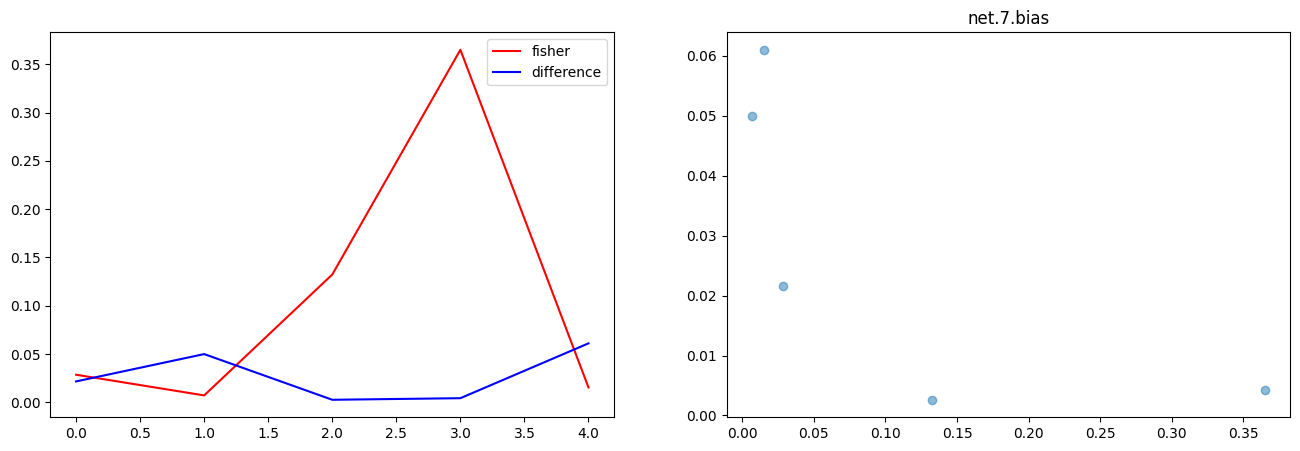


net.9.weight
torch.Size([10, 20])
Max fisher is 0.13682 and it's parameter diff is 0.00077
Min Parameter diff is 0.66325 and it's fisher is 0.00093
fisher > parameter diff: 8
fisher <= parameter diff: 12


<Figure size 640x480 with 0 Axes>

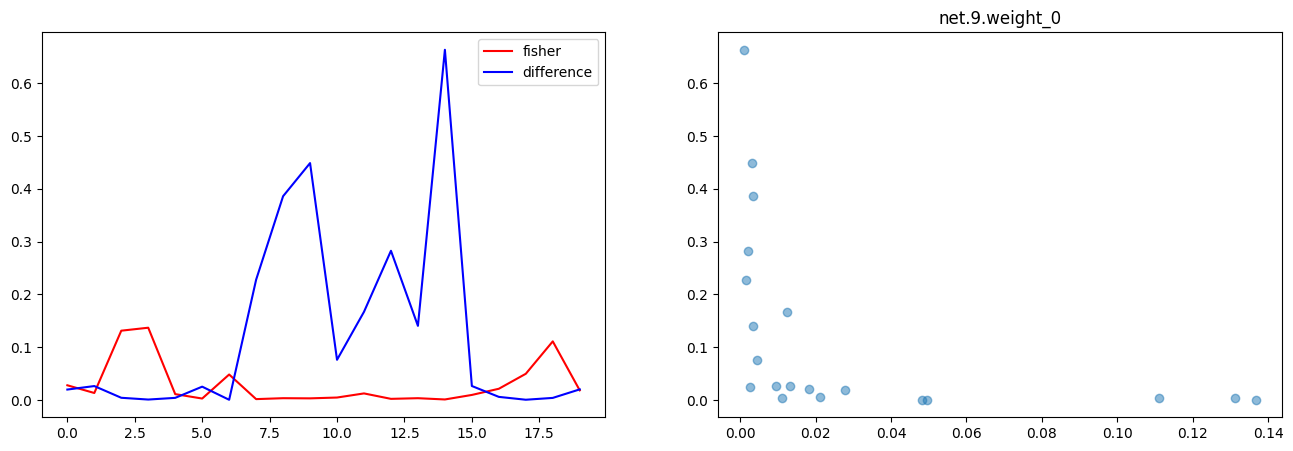

Max fisher is 0.73737 and it's parameter diff is 0.00147
Min Parameter diff is 0.64721 and it's fisher is 0.00125
fisher > parameter diff: 12
fisher <= parameter diff: 8


<Figure size 640x480 with 0 Axes>

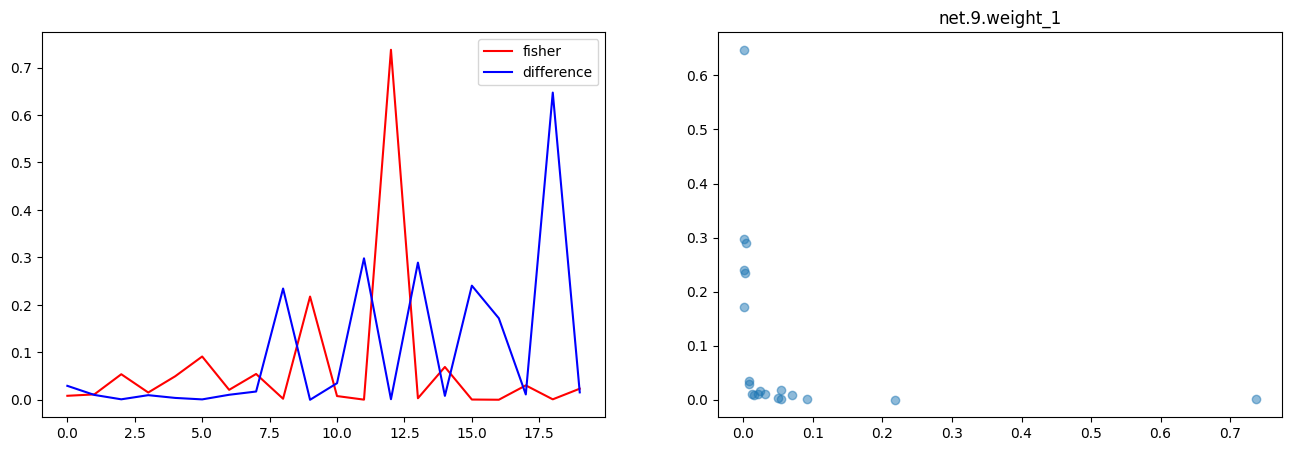

Max fisher is 0.52230 and it's parameter diff is 0.00130
Min Parameter diff is 0.37478 and it's fisher is 0.00827
fisher > parameter diff: 11
fisher <= parameter diff: 9


<Figure size 640x480 with 0 Axes>

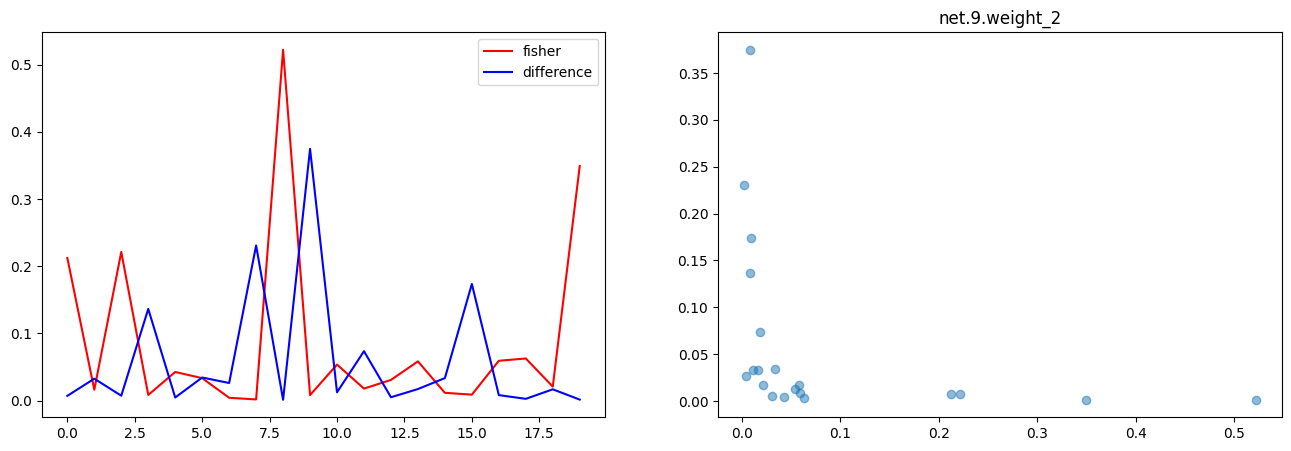

Max fisher is 0.61908 and it's parameter diff is 0.00161
Min Parameter diff is 0.42709 and it's fisher is 0.00432
fisher > parameter diff: 10
fisher <= parameter diff: 10


<Figure size 640x480 with 0 Axes>

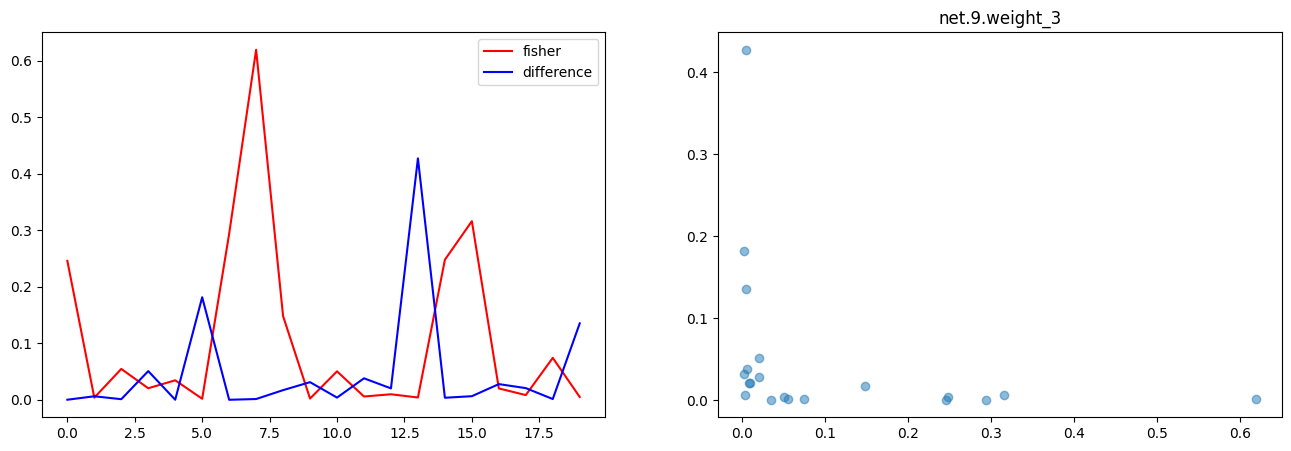

Max fisher is 0.12691 and it's parameter diff is 0.00300
Min Parameter diff is 0.37076 and it's fisher is 0.00340
fisher > parameter diff: 8
fisher <= parameter diff: 12


<Figure size 640x480 with 0 Axes>

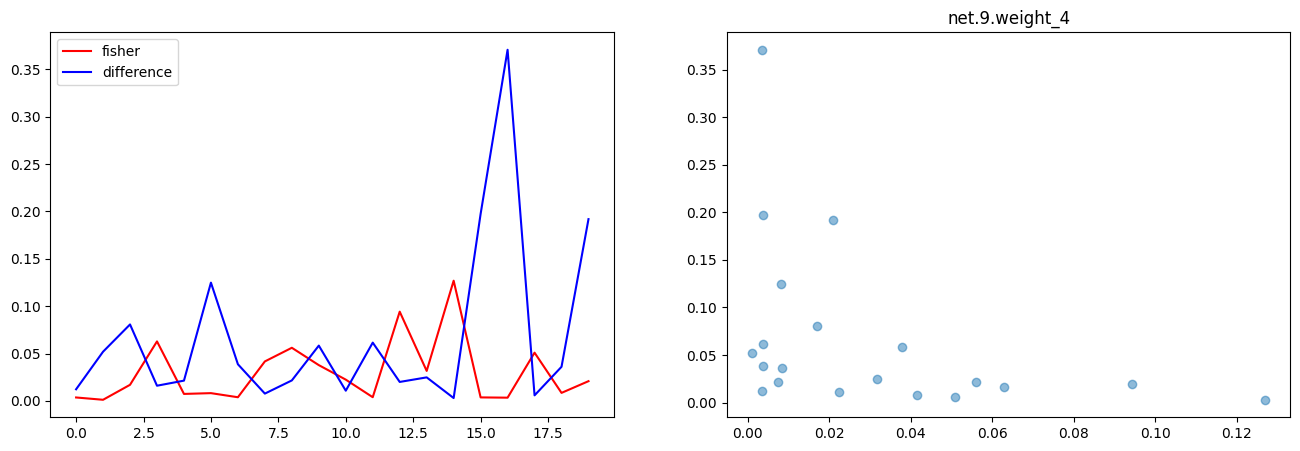

Max fisher is 0.07369 and it's parameter diff is 0.00922
Min Parameter diff is 0.18902 and it's fisher is 0.00353
fisher > parameter diff: 6
fisher <= parameter diff: 14


<Figure size 640x480 with 0 Axes>

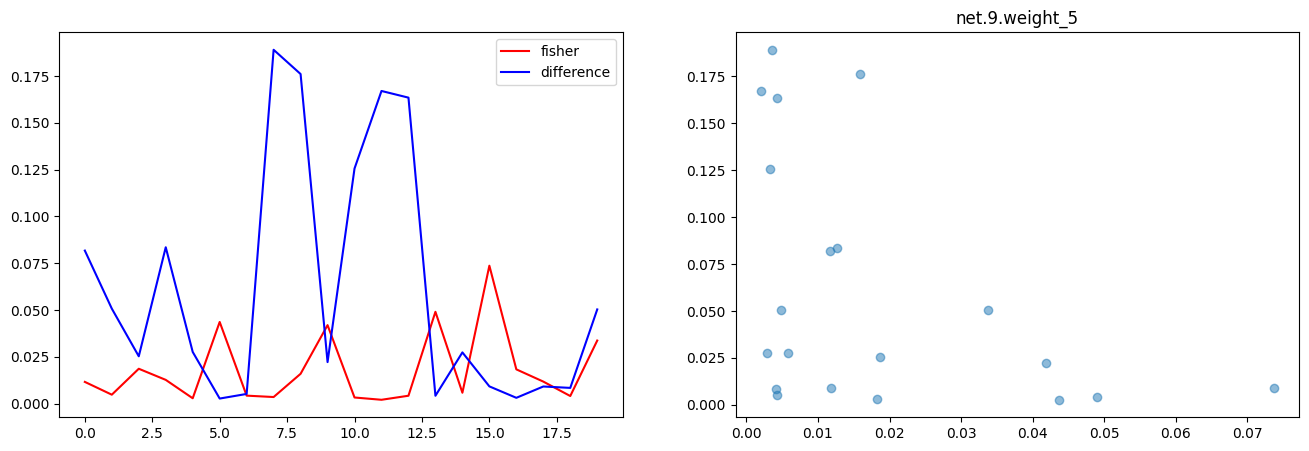

Max fisher is 0.24359 and it's parameter diff is 0.00254
Min Parameter diff is 0.44482 and it's fisher is 0.00817
fisher > parameter diff: 11
fisher <= parameter diff: 9


<Figure size 640x480 with 0 Axes>

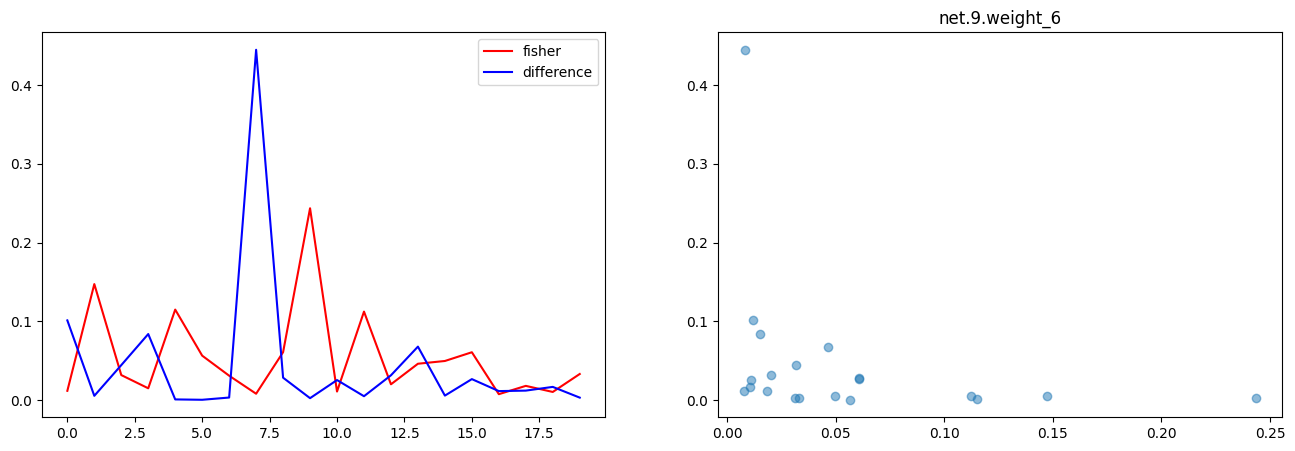

Max fisher is 2.36571 and it's parameter diff is 0.00084
Min Parameter diff is 0.22451 and it's fisher is 0.00552
fisher > parameter diff: 16
fisher <= parameter diff: 4


<Figure size 640x480 with 0 Axes>

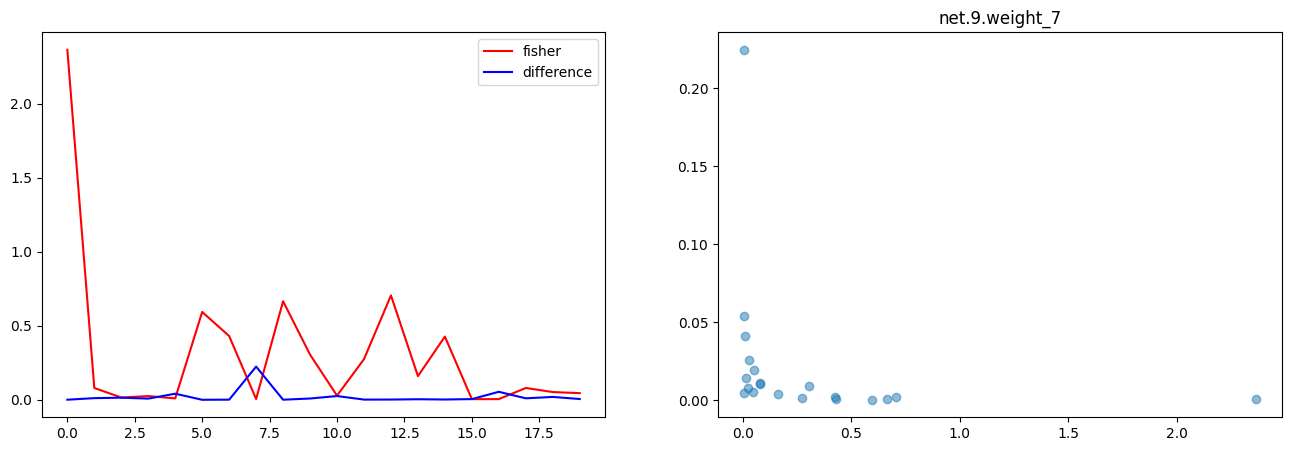

Max fisher is 0.09977 and it's parameter diff is 0.00371
Min Parameter diff is 0.28656 and it's fisher is 0.00150
fisher > parameter diff: 10
fisher <= parameter diff: 10


<Figure size 640x480 with 0 Axes>

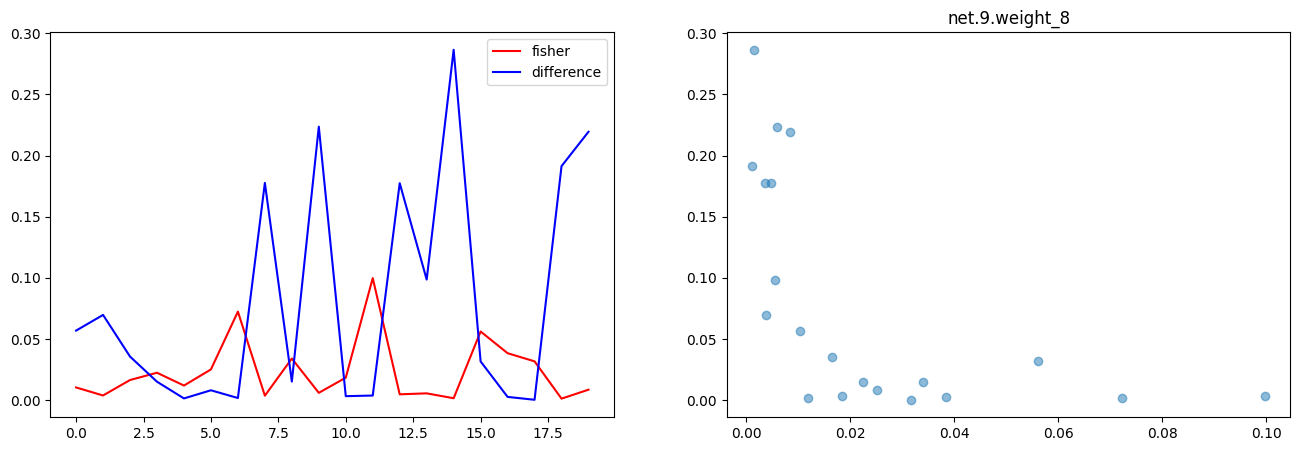

Max fisher is 0.81748 and it's parameter diff is 0.00130
Min Parameter diff is 0.10808 and it's fisher is 0.00778
fisher > parameter diff: 15
fisher <= parameter diff: 5


<Figure size 640x480 with 0 Axes>

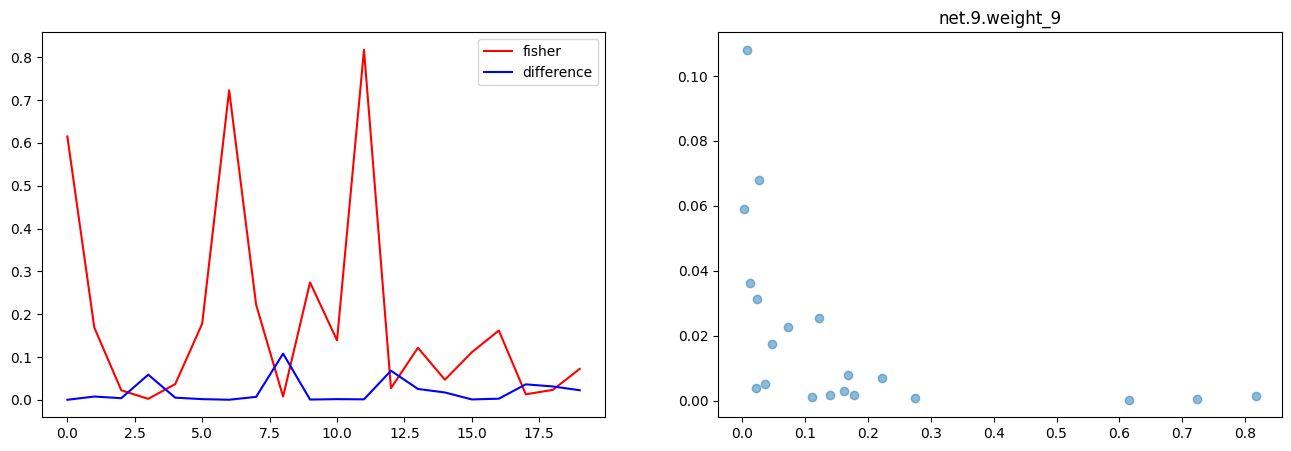


net.9.bias
torch.Size([10])
Max fisher is 0.34975 and it's parameter diff is 0.00262
Min Parameter diff is 0.02035 and it's fisher is 0.00510
fisher > parameter diff: 8
fisher <= parameter diff: 2


<Figure size 640x480 with 0 Axes>

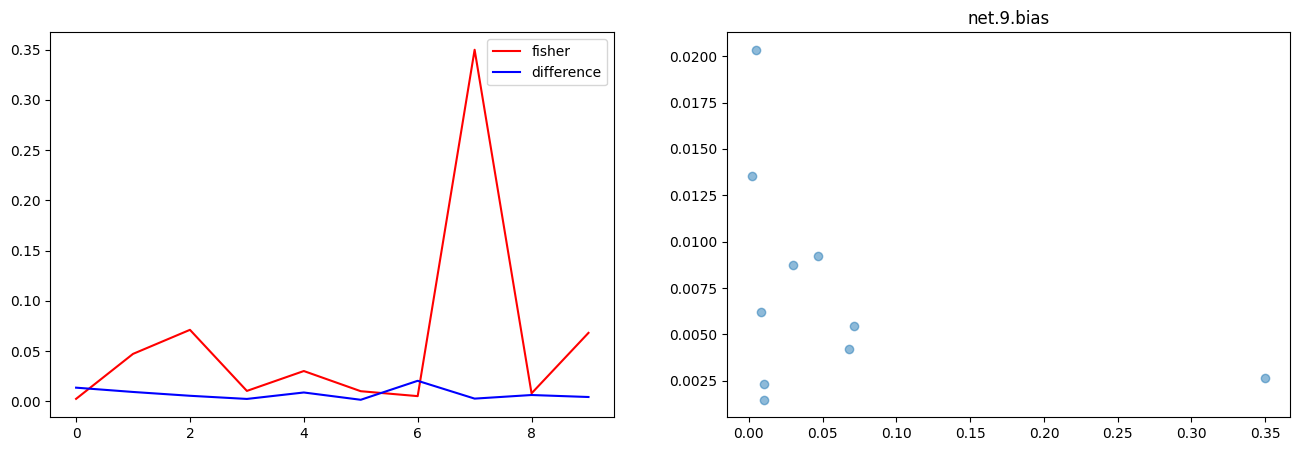

In [68]:
def plot(fisher_matrix, optim_para, param, name):
  plt.cla(); plt.clf()
  #print(fisher_matrix.shape, optim_para.shape, param.shape)
  fisher = fisher_matrix.cpu().detach()
  optim = optim_para.cpu().detach()
  param = param.cpu().detach()

  fisher_max = np.argmax(fisher)
  param_diff_max = np.argmax((optim - param).abs())
  print(f'Max fisher is {fisher[fisher_max]:.5f} and it\'s parameter diff is {(optim - param).abs()[fisher_max]:.5f}')
  print(f'Min Parameter diff is {(optim - param).abs()[param_diff_max]:.5f} and it\'s fisher is {fisher[param_diff_max]:.5f}')
  # compare
  print('fisher > parameter diff: {}'.format((fisher > (optim - param).abs()).sum()))
  print('fisher <= parameter diff: {}'.format((fisher <= (optim - param).abs()).sum()))

  # plot
  fig, ax = plt.subplots(1, 2, figsize=(16, 5)) # row, col
  ax[0].plot(fisher.reshape(-1), 'r', label='fisher')
  ax[0].plot((optim - param).abs().reshape(-1), 'b', label='difference')
  ax[0].legend()

  ax[1].scatter(fisher, (optim - param).abs().reshape(-1), alpha=0.5)
  plt.title(name)
  plt.show()

# test
idx = 0
for name, param in model.named_parameters():

  # Name
  print(name)
  print(param.detach().shape)

  if len(param.detach().shape) != 1:
    for i in range(param.detach().shape[0]):
      plot(fisher_matrix[0][name][i].flatten(), optim_para[0][name][i].flatten(), param[i].flatten(), f'{name}_{i}')
  else:
    plot(fisher_matrix[0][name], optim_para[0][name], param, name)
  # END
  idx += 1
  print()

In [69]:
import datetime
import pytz

now = datetime.datetime.now(pytz.timezone('Asia/Taipei')).strftime("%Y-%m-%d_%H_%M_%S")
print(now)

2025-03-25_21_51_15
